# A

In [1]:
#!/usr/bin/env python

# coding: utf-8

# %% Loading Packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_erIPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')ror


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.activations import tanh
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import MSE, MAE, MAPE
from tensorflow.keras.metrics import Accuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import kullback_leibler_divergence, SparseCategoricalCrossentropy, KLDivergence
from tensorflow.keras.callbacks import LearningRateScheduler

import sys

from tensorflow.python.ops.gen_batch_ops import batch

import sys
import os
import sys
import platform

from tensorflow.python.ops.gen_math_ops import Tanh
if platform.node() in ['msbq']:
    os.chdir('/home/ms/github/fxpred')
    # os.chdir('../.')
    sys.path.append(os.path.join(os.getcwd(), 'Transformer'))
# from utils import data_read_dict, data_read_concat, data_merge
from utils import get_fx_and_metric_data_wo_weekend, mde
from utils_NN_opt_learning_rate import opt_learn_rate_plot
from benchmark_utils import actual_pred_plot

from benchmark_utils import ts_train_test_normalize


name = 'LSTM_multivariate_classification'

/home/ms/github/venv/fxpred3/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [2]:
dtype = np.float32  # np.float64
tf.keras.backend.set_floatx('float32')
# %% read in data and adapt
df = get_fx_and_metric_data_wo_weekend(dtype=dtype)
target = 'EURUSD BGNE Curncy Bid Close'
# target_column = [i for i in df.columns.tolist() if 'Bid Close' in i]
# target_column_id = [list(df.columns).index(i) for i in target_column]
target_column_id = list(df.columns).index(target)

In [3]:
# create a list of our conditions #!!! 
conditions = [
    (df[target] <= -0.00000001),
    (df[target] > -0.00000001) & (df[target] <= 0.00000001),
    (df[target] > 0.00000001)
]

# create a list of the values we want to assign for each condition #!!! 
values = ['sell', 'hold', 'buy']
values = [0, 1, 2]

# create a new column and use np.select to assign values to it using our lists as arguments #!!! 
df['strategy'] = np.select(conditions, values)
df.strategy = df.strategy.astype(np.int32)

# display updated DataFrame #!!! 
df.head()

,EURUSD BGNE Curncy Bid Open,EURUSD BGNE Curncy Bid Close,EURUSD BGNE Curncy Bid High,EURUSD BGNE Curncy Bid Low,EURUSD BGNE Curncy Bid Number Ticks,EURUSD BGNE Curncy Ask Open,EURUSD BGNE Curncy Ask Close,EURUSD BGNE Curncy Ask High,EURUSD BGNE Curncy Ask Low,EURUSD BGNE Curncy Ask Number Ticks,...,usdjpy___TAS_D,usdjpy___TAS_DS,usdjpy___TAS_DSS,usdjpy___TRENDER_UP,usdjpy___TRENDER_DN,usdjpy___TMAVG,usdjpy___VMAVG,usdjpy___WMAVG,usdjpy___WLPR,strategy
Dates,,,,,,,,,,,,,,,,,,,,,
2020-11-01 19:10:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,56.0,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664,1
2020-11-01 19:20:00,0.000283,0.000275,0.000197,-0.000507,-0.978125,0.002121,0.001597,0.001631,0.001761,-0.978125,...,56.0,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664,2
2020-11-01 19:30:00,0.000172,-0.000069,0.000017,-0.000215,0.380952,0.000043,0.000017,0.000086,0.000137,0.380952,...,56.0,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664,0
2020-11-01 19:40:00,0.000060,0.000034,-0.000172,0.000636,3.310345,-0.000274,-0.001157,-0.000009,-0.000926,3.310345,...,56.0,62.133335,67.244446,104.536598,104.576935,104.551109,104.620003,104.553337,-66.666664,2
2020-11-01 19:50:00,-0.000026,0.000026,-0.000026,0.000584,-0.984000,-0.000909,-0.000009,-0.001268,0.000017,-0.984000,...,56.0,62.133335,67.244446,104.536598,104.576935,104.552223,104.620003,104.552666,-66.666664,2


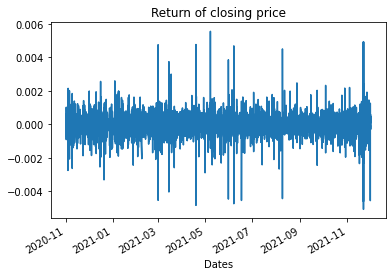

In [4]:
df['EURUSD BGNE Curncy Bid Close'].plot()
plt.title('Return of closing price')
plt.show()

In [5]:
# X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test = \
#     ts_train_test_normalize(df, 64, 1, [i for i in target_columns_id])

lag = 128
h = 1
X_train, y_train, X_val, y_val , X_test, y_test, sc, sc_target, index_train, index_val, index_test, X_train_index, y_train_index = \
    ts_train_test_normalize(df, lag, h, df.columns.to_list().index('strategy'), dtype=dtype)

In [6]:
X_train = X_train#.astype(dtype)
X_val = X_val#.astype(dtype)
X_test = X_test#.astype(dtype)
y_train = sc_target.inverse_transform(y_train).round()
y_val = sc_target.inverse_transform(y_val).round()
y_test = sc_target.inverse_transform(y_test).round()

In [7]:
def LSTM_model():
    # The LSTM architecture
    loss_fct = 'tanh'
    dr = 0.5
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units=256, activation=loss_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=256, activation=loss_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=256, activation=loss_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=256, activation=loss_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(LSTM(units=128, activation=loss_fct, return_sequences=True, dropout=dr))
    my_LSTM_model.add(BatchNormalization())
    my_LSTM_model.add(Flatten())
    my_LSTM_model.add(Dense(units=3, activation='softmax'))
    return my_LSTM_model

In [8]:
def predictions(my_model, X_test, sc=None):
    LSTM_prediction = my_model.predict(X_test)
    if sc is not None:
        LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    return LSTM_prediction

In [9]:
def earlyStopping():
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=10,
        verbose=0,
        mode="auto",
        baseline=None,
        restore_best_weights=True,
    )
if not os.path.exists('Benchmark/trained_models'):
    os.mkdir('Benchmark/trained_models')
model_checkpoints = tf.keras.callbacks.ModelCheckpoint(
    'Benchmark/trained_models/%s____{epoch:04}.hdf5'%name,
    monitor='val_loss',
    save_best_only=False,
    verbose=1
)
def learning_rate_scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0005
    elif epoch < 50:
        return 0.0001
    elif epoch < 100:
        return 0.00001
    else:
        return 0.000001

In [10]:
from tensorflow.keras.optimizers import Adam
my_LSTM_model = LSTM_model()
my_LSTM_model.compile(
    optimizer=Adam(
        learning_rate=0.05
    ),
    loss=SparseCategoricalCrossentropy(from_logits=False),
#     loss='accuracy',
    metrics=['kullback_leibler_divergence', 'accuracy'],
)

history = my_LSTM_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1,
    shuffle=True,
    callbacks=[
        # earlyStopping(),
        LearningRateScheduler(learning_rate_scheduler),
        model_checkpoints,
        tf.keras.callbacks.TerminateOnNaN()
    ]
)

Epoch 1/100
1045/1045 [==============================] - 54s 47ms/step - loss: 1.4872 - kullback_leibler_divergence: 4.6510 - accuracy: 0.4670 - val_loss: 2.2317 - val_kullback_leibler_divergence: 9.8793 - val_accuracy: 0.4801

Epoch 00001: saving model to Benchmark/trained_models/LSTM_multivariate_classification____0001.hdf5
Epoch 2/100
1045/1045 [==============================] - 47s 45ms/step - loss: 1.1191 - kullback_leibler_divergence: 3.4666 - accuracy: 0.4836 - val_loss: 0.8423 - val_kullback_leibler_divergence: 3.0940 - val_accuracy: 0.4813

Epoch 00002: saving model to Benchmark/trained_models/LSTM_multivariate_classification____0002.hdf5
Epoch 3/100
1045/1045 [==============================] - 47s 45ms/step - loss: 0.9363 - kullback_leibler_divergence: 2.8676 - accuracy: 0.4799 - val_loss: 0.8319 - val_kullback_leibler_divergence: 2.9225 - val_accuracy: 0.4840

Epoch 00003: saving model to Benchmark/trained_models/LSTM_multivariate_classification____0003.hdf5
Epoch 4/100
1045

In [12]:
import pickle 
with open(f'Benchmark/trained_models/{name}____history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [13]:
if 'my_LSTM_model' not in globals():
    model_last = sorted([i for i in os.listdir('Benchmark/trained_models/') if name + '__' in i and 'hdf5' in i])[-1]
    my_LSTM_model = tf.keras.models.load_model(
        os.path.join('Benchmark/trained_models', model_last)
    )
if 'history' not in globals():
    with open(f'Benchmark/trained_models/{name}____history.pkl', 'rb') as f:
        history = pickle.load(f)
if hasattr(history, 'history'):
    history = history.history

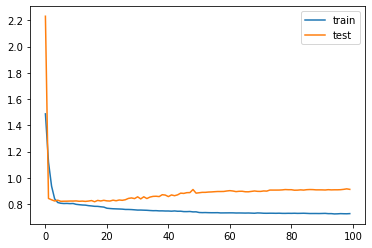

In [15]:
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='test')
plt.legend()
plt.show()

In [16]:
my_LSTM_model.summary()
my_LSTM_model.layers[1].get_weights()[2].dtype

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128, 256)          1531904   
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 256)          1024      
_________________________________________________________________
lstm_1 (LSTM)                (None, 128, 256)          525312    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 256)          1024      
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 256)          525312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 256)          1024      
_________________________________________________________________
lstm_3 (LSTM)                (None, 128, 256)          5

dtype('float32')

In [ ]:
opt_learn_rate_plot(
    my_LSTM_model,
    X_train,
    y_train,
    10**-6,
    10**1,
    100,
    batch_size=64,
    steps_per_epoch=1,
    custom_objects={'kl_divergence': kullback_leibler_divergence}
)